Benchmarking wc with 5000 iterations...
Benchmarking ./wc.o with 5000 iterations...
Benchmarking ./wc_v2.o with 5000 iterations...


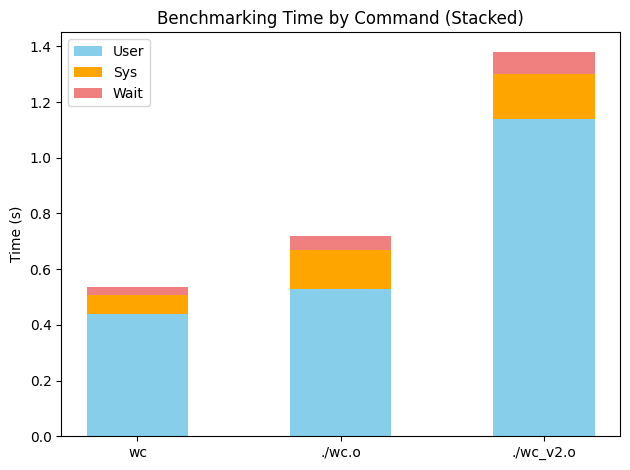

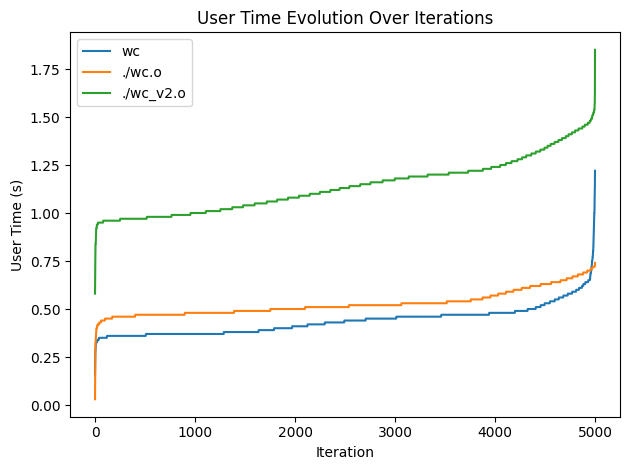

In [20]:
import subprocess
import re
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import defaultdict

# List of commands to benchmark
commands = {
    "wc": "cat /var/log/syslog | wc",
    "./wc.o": "cat /var/log/syslog | ./wc.o",
    "./wc_v2.o": "cat /var/log/syslog | ./wc_v2.o"
}

# Function to run a single timed benchmark
def run_single_benchmark(command):
    result = subprocess.run(
        ["/usr/bin/time", "-p", "bash", "-c", command],
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True
    )
    stderr = result.stderr
    try:
        times = {
            k: float(v)
            for k, v in re.findall(r'(real|user|sys)\s+([\d.]+)', stderr)
        }
        real = times.get('real', 0)
        user = times.get('user', 0)
        sys = times.get('sys', 0)
        wait = max(0.0, real - (user + sys))
        return real, user, sys, wait
    except Exception as e:
        print("Failed to parse time for command:", command)
        print(stderr)
        return 0.0, 0.0, 0.0, 0.0

# Run multiple iterations of a command in parallel and collect all user times
def benchmark_command_parallel(command, iterations):
    real_times, user_times, sys_times, wait_times = [], [], [], []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(run_single_benchmark, command) for _ in range(iterations)]
        for future in as_completed(futures):
            real, user, sys, wait = future.result()
            real_times.append(real)
            user_times.append(user)
            sys_times.append(sys)
            wait_times.append(wait)

    avg_real = sum(real_times) / iterations
    avg_user = sum(user_times) / iterations
    avg_sys = sum(sys_times) / iterations
    avg_wait = sum(wait_times) / iterations

    return {
        'avg': (avg_real, avg_user, avg_sys, avg_wait),
        'user_times': user_times
    }

# Run benchmarks for all commands
def run_benchmarks(iterations=5):
    results = {}
    for label, cmd in commands.items():
        print(f"Benchmarking {label} with {iterations} iterations...")
        results[label] = benchmark_command_parallel(cmd, iterations)
    return results

# Plot stacked bar of average times
def plot_summary(results):
    labels = list(results.keys())
    user_times = [results[k]['avg'][1] for k in labels]
    sys_times = [results[k]['avg'][2] for k in labels]
    wait_times = [results[k]['avg'][3] for k in labels]

    x = np.arange(len(labels))
    width = 0.5

    fig, ax = plt.subplots()
    ax.bar(x, user_times, width, label='User', color='skyblue')
    ax.bar(x, sys_times, width, bottom=user_times, label='Sys', color='orange')
    bottom_stack = [u + s for u, s in zip(user_times, sys_times)]
    ax.bar(x, wait_times, width, bottom=bottom_stack, label='Wait', color='lightcoral')

    ax.set_ylabel('Time (s)')
    ax.set_title('Benchmarking Time by Command (Stacked)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot user time evolution
def plot_user_time_evolution(results):
    fig, ax = plt.subplots()
    for label, data in results.items():
        user_times = data['user_times']
        ax.plot(sorted(user_times), label=label)  # sorted to show trends more clearly
    ax.set_xlabel('Iteration')
    ax.set_ylabel('User Time (s)')
    ax.set_title('User Time Evolution Over Iterations')
    ax.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    iterations = 5000  # Adjust as needed
    results = run_benchmarks(iterations)
    plot_summary(results)
    plot_user_time_evolution(results)
